# 1.1: Simple ODE Example - From Scratch with PyTorch

This Jupyter Notebook provides a from-scratch implementation of a Physics-Informed Neural Network (PINN) to solve a simple first-order Ordinary Differential Equation (ODE). This serves as the first practical example in the course, demonstrating the core principles without relying on high-level libraries.

### Problem Definition:
- **ODE**: $\frac{dy}{dx} + y = 0$
- **Initial Condition**: $y(0) = 1$
- **Domain**: $x \in [0, 5]$
- **Analytical Solution**: $y(x) = e^{-x}$

We will walk through each step of the process:
1.  Defining the neural network architecture.
2.  Constructing the composite loss function (the core of the PINN).
3.  Training the network.
4.  Visualizing and validating the results.


In [5]:
import torch

In [6]:
# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
else:
    print("CUDA is not available. Using CPU.")


Device: cuda
CUDA Device: NVIDIA RTX A1000 6GB Laptop GPU
CUDA Version: 11.8
Number of CUDA devices: 1


In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better plots and consistent visualization
sns.set_style("whitegrid")
print(f"PyTorch Version: {torch.__version__}")


PyTorch Version: 2.7.1+cu118


## 1. Neural Network Definition

First, we define the neural network that will serve as our solution surrogate, $y_{\theta}(x)$. A simple feed-forward neural network is a universal function approximator, making it a suitable candidate to represent the solution of the ODE.

The network takes a single input, $x$, and produces a single output, our predicted value for $y(x)$.


In [8]:
# Represents the candidate solution y_theta(x)
class PINN(nn.Module):
    """
    A simple Feed-Forward Neural Network with Tanh activation functions.
    """
    def __init__(self):
        super(PINN, self).__init__()
        # Using nn.Sequential for a straightforward layer stack
        self.net = nn.Sequential(
            nn.Linear(1, 32),  # Input layer: 1 feature (x)
            nn.Tanh(),
            nn.Linear(32, 32), # Hidden layer
            nn.Tanh(),
            nn.Linear(32, 1)   # Output layer: 1 feature (y)
        )

    def forward(self, x):
        """Forward pass: maps input x to output y."""
        return self.net(x)


## 2. Loss Function Construction

This is the most critical part of the PINN methodology. The total loss, $\mathcal{L}_{total}$, is a composite loss function that combines the physics-informed loss from the ODE and the data-driven loss from the initial condition.

$\mathcal{L}_{total} = \mathcal{L}_{ode} + \mathcal{L}_{ic}$

-   **ODE Residual Loss ($\mathcal{L}_{ode}$)**: This loss enforces the governing equation. We define the ODE residual as $r(x) = \frac{dy_{\theta}}{dx} + y_{\theta}$. The loss is the Mean Squared Error (MSE) of this residual over a set of randomly sampled points in the domain (collocation points). The key technology here is **Automatic Differentiation (AD)**, which PyTorch provides via `torch.autograd.grad`, to compute the derivative $\frac{dy_{\theta}}{dx}$ exactly.

-   **Initial Condition Loss ($\mathcal{L}_{ic}$)**: This is a standard data-driven loss. It's the MSE between the network's prediction at $x=0$ and the true initial value, $y(0)=1$.


In [9]:
def get_losses(model, x_domain, x0, y0):
    """
    Computes the composite loss for the PINN.
    
    Args:
        model (nn.Module): The neural network representing the solution.
        x_domain (torch.Tensor): Collocation points for enforcing the ODE.
        x0 (torch.Tensor): The point for the initial condition.
        y0 (torch.Tensor): The value for the initial condition.
        
    Returns:
        tuple: A tuple containing the total loss, ODE loss, and initial condition loss.
    """
    # --- a. ODE Residual Loss (L_ode) ---
    # Enforce the governing equation: dy/dx + y = 0
    
    # Enable gradient computation for the input tensor
    x_domain.requires_grad_(True)
    
    # Get the network's prediction for y at the collocation points
    y_pred = model(x_domain)
    
    # Use torch.autograd.grad to compute the derivative dy/dx
    # This is the key step where Automatic Differentiation is used.
    # grad_outputs must be specified and have the same shape as y_pred.
    # create_graph=True allows for computing higher-order derivatives if needed.
    dy_dx = torch.autograd.grad(
        y_pred, x_domain, 
        grad_outputs=torch.ones_like(y_pred), 
        create_graph=True
    )[0]
    
    # Calculate the residual of the ODE
    residual = dy_dx + y_pred
    
    # The loss is the Mean Squared Error of the residual
    loss_ode = torch.mean(residual**2)
    
    # --- b. Initial Condition Loss (L_ic) ---
    # Enforce the constraint y(0) = 1
    y0_pred = model(x0)
    loss_ic = torch.mean((y0_pred - y0)**2)
    
    # --- c. Total Loss ---
    total_loss = loss_ode + loss_ic
    
    return total_loss, loss_ode, loss_ic


## 3. Training the PINN

Now we set up and run the training loop. This process is similar to training a standard neural network, with a key difference: we are not training against a large dataset of `(x, y)` pairs. Instead, the "data" is the physical law itself, enforced via the loss function at the collocation points.

The steps are:
1.  Instantiate the `PINN` model.
2.  Set up an optimizer (e.g., Adam).
3.  Define the computational domain (collocation points) and the initial condition point.
4.  Run a loop for a set number of epochs, where in each epoch we:
    -   Calculate the total loss.
    -   Perform backpropagation.
    -   Update the network weights with the optimizer.


In [10]:
# --- Training Setup ---

# Instantiate the model
pinn = PINN()
print("Model Architecture:")
print(pinn)

# Setup the optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# Define the computational domain and initial condition
# Collocation points for the ODE loss
x_domain = torch.linspace(0, 5, 100, requires_grad=True).view(-1, 1)
# Initial condition point
x0 = torch.tensor([[0.0]])
y0 = torch.tensor([[1.0]])


# --- Training Loop ---

epochs = 10000
for epoch in range(epochs):
    # Set model to training mode
    pinn.train()
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Calculate losses
    total_loss, loss_ode, loss_ic = get_losses(pinn, x_domain, x0, y0)
    
    # Backpropagate the total loss
    total_loss.backward()
    
    # Update the model parameters
    optimizer.step()
    
    # Print progress
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {total_loss.item():.6f}, '
              f'ODE Loss: {loss_ode.item():.6f}, IC Loss: {loss_ic.item():.6f}')


Model Architecture:
PINN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Epoch [1000/10000], Total Loss: 0.000060, ODE Loss: 0.000060, IC Loss: 0.000000
Epoch [2000/10000], Total Loss: 0.000011, ODE Loss: 0.000011, IC Loss: 0.000000
Epoch [3000/10000], Total Loss: 0.000008, ODE Loss: 0.000008, IC Loss: 0.000000
Epoch [4000/10000], Total Loss: 0.000006, ODE Loss: 0.000006, IC Loss: 0.000000
Epoch [5000/10000], Total Loss: 0.000004, ODE Loss: 0.000004, IC Loss: 0.000000
Epoch [6000/10000], Total Loss: 0.000002, ODE Loss: 0.000002, IC Loss: 0.000000
Epoch [7000/10000], Total Loss: 0.000002, ODE Loss: 0.000002, IC Loss: 0.000000
Epoch [8000/10000], Total Loss: 0.000021, ODE Loss: 0.000017, IC Loss: 0.000004
Epoch [9000/10000], Total Loss: 0.000000, ODE Loss: 0.000000, IC Loss: 0.000000
Epoch [10000/1000

## 4. Validation & Visualization

After training is complete, we evaluate our PINN's performance. We do this by comparing its prediction over a dense range of points against the known analytical solution. A close match indicates that our network has successfully learned to approximate the solution of the ODE.


### Final Quantitative Check

Finally, let's do a quick numerical check to see how well the network satisfied the initial condition after training.


In [11]:
# Final quantitative check at the initial condition
with torch.no_grad():
    y0_final_pred = pinn(x0)
print(f"Final prediction at x=0: {y0_final_pred.item():.6f}")
print(f"True value at x=0: {y0.item():.6f}")


Final prediction at x=0: 0.999999
True value at x=0: 1.000000


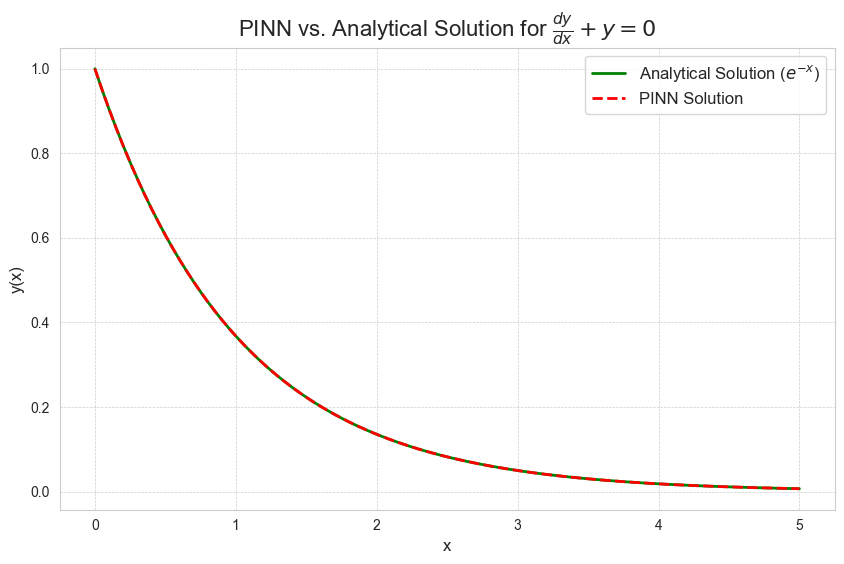

In [12]:
# Set model to evaluation mode
pinn.eval()

# Generate a dense set of points for a smooth plot
x_test = torch.linspace(0, 5, 200).view(-1, 1)

# Get the PINN's prediction
with torch.no_grad():
    y_pinn = pinn(x_test)

# Get the analytical solution
y_analytical = torch.exp(-x_test)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_test.numpy(), y_analytical.numpy(), label='Analytical Solution ($e^{-x}$)', color='green', linewidth=2)
plt.plot(x_test.numpy(), y_pinn.numpy(), label='PINN Solution', color='red', linestyle='--', linewidth=2)
plt.title('PINN vs. Analytical Solution for $\\frac{dy}{dx} + y = 0$', fontsize=16)
plt.xlabel('x', fontsize=12)
plt.ylabel('y(x)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
